![title](notebook_images/logo.png)

# Biometrics System Concepts
# Assignment 3: Face Recognition
In this assignment, you will test/implement and report about a face recognition algorithm based on Principal Components Analysis (Eigenfaces), Linear Discriminant Analysis (Fisherfaces), Local Binary Pattern (LBP) and deep learning. The first three procedures are representative of old-school computer vision techniques that are still in use and retain their merits. All four generated feature vector descriptors that can be compared for verification/identification.

The structure of this document follows a typical face recognition pipeline and consists of the following major sections: 
1. Loading Image Data
2. Detecting faces in the images
3. Extracting features
4. Classification in typical biometrics setting
5. Advanced classification systems
6. Evaluation
7. Task


**Note: large parts of this notebook are based on the [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock.**

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


## Importing and installing packages
Note: this exercise makes use of keras, which is now part of TensorFlow 2.0. It is easy to install using pip, have a look at the [installation guide](https://www.tensorflow.org/install) for more information. Note that you need Python Version 3.5 to 3.7 for this to run (not lower, not higher).

In [329]:
import numpy as np
import cv2
from pathlib import Path

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline

# the following package contains some handy routines for image manipulation
# they have been developed by Adrian Rosenbrock
# simply install this package in your environment using "conda install imutils"
# see https://www.pyimagesearch.com/opencv-tutorials-resources-guides/ for further info
import imutils
from tqdm import tqdm

##import library from Assigment1 to evaluate biometric systems
from Evaluation import Metrics
#Import library CMC developed in Assigment1 to compute CMC curves
from CMC import CMC
import pandas as pd
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np
import os
from numpy import interp
from sklearn.metrics import auc, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score,f1_score


## 1. Loading an image datasets

[From OpenCV Docs](https://docs.opencv.org/3.4/da/d60/tutorial_face_main.html):

In order to test face recognition systems, we need databases of labeled face images. You can either create your own dataset (but that takes time) or, better, start with one of the available face databases, http://face-rec.org/databases/ gives you an up-to-date overview. Some interesting databases are:

* [AT&T Facedatabase](http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html). Quoted from http://face-rec.org):
> The AT&T Facedatabase, sometimes also referred to as ORL (Olivetti Research Lab) Database of Faces or Olivetti faces, contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).The AT&T Facedatabase is good for initial tests, but it's a fairly easy database. The Eigenfaces method already has a 97% recognition rate on it, so you won't see any great improvements with other algorithms.

This database can be accessed in a straightforward way through the [sklearn.datasets.fetch_olivetti_faces](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces) module. 
A preview of this database can be seen [here](https://www.cl.cam.ac.uk/research/dtg/attarchive/facesataglance.html) 

* [The CALTECH Faces dataset](http://www.vision.caltech.edu/html-files/archive.html) is a popular benchmark dataset for face recognition algorithms. Overall, the dataset consists of 450 images of approximately 27 unique people. Each subject was captured under various lighting conditions, background scenes, and facial expressions. Furthermore, bounding box coordinates are provided to crop the faces prior to recognition. A routine (load_caltech_faces)is provided to read the data. 

![A sample of the CALTECH Faces dataset.](notebook_images/lbps_fr_caltech_faches.jpg)

* [The Labeled Faces in the Wild (lfw)](http://vis-www.cs.umass.edu/lfw/). This dataset is a collection of more than 13000 JPEG pictures of famous people collected over the internet. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. These images are completely unconstrained (pose, illumination, expression, occlusion).  The only constraint on these faces is that they were detected by the Viola-Jones face detector. Each picture is centered on a single face. A loader [sklearn.datasets.fetch_lfw_people](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html#sklearn.datasets.fetch_lfw_people) is provided by scikit-learn. 


### 1.1 Read caltech dataset
For this assignemnt we'll work with the CALTECH dataset because it contains raw images and is not very large. 

The data are returned as a list object with the following components:
* data: (NxM) matrix of N flattened (linear dimension M) images
* images: (Nx(nxm)) matrix of N images of dimension nxm 
* target: N-dimensional vector of labels 

In [3]:
# size of each face after preprocessing
face_size=(47, 47)

In [ ]:
import pandas as pd

def read_img(imagePath):
    # load the image and convert it to grayscale
    gray = cv2.imread(str(imagePath), cv2.IMREAD_GRAYSCALE)

    # ROI, and resize it to a canonical size
    imagePathStem = str(imagePath.stem)
    k = int(imagePathStem[imagePathStem.rfind("_") + 1:][:4]) - 1
    

    return gray, imagePath.parent.name
     
# grab in all the subdirs all the image paths associated with the faces
datasetPath = Path("/gdrive/My Drive/Assigment3/CalTechFacesDirs")
imagePaths = datasetPath.glob("*/*.jpg")

# read image and label information
imgs = [read_img(imagePath) for imagePath in imagePaths]
data = pd.DataFrame(imgs, columns =['images', 'target']).to_dict('list')

# check if all images were found successfully (5 images were removed from the original set)
assert len(data['images']) == len(data['target']) == 445

In [4]:
import pickle
with open("/gdrive/My Drive/Assigment3/data.txt","rb") as f:
  data = pickle.load(f)

### 2.2. Inspect some images

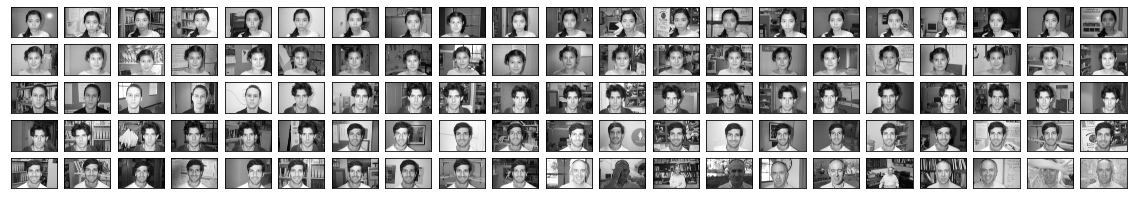

In [ ]:
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 21), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, data['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## 2. Detecting faces


Even though the bounding box coordinates are stored in the <em>CalTechFacesDirs/ImageData.mat</em> file, we'll be computing them from scratch for demonstrative purposes. 

### 2.1. Detect faces
There are many different face detection algorithms, you can follow the [Learn OpenCV tutorial on Face Detection](https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/) for some (very coarse) background info for two "conventional" (HAAR-cascade, HOG) CV methods and two Deep Neural Net (Dlib) based (SSD, MMOD) methods. Please study the relevant publications on these detectors to understand their functioning.

* Some background on Haar, HOG and MMOD face detectors can be found in this [Guide to Face Detection in Python](https://towardsdatascience.com/a-guide-to-face-detection-in-python-3eab0f6b9fc1). 

* For MMOD specifically, see: [Max-Margin Object Detection by Davis E. King](http://arxiv.org/abs/1502.00046) and the comments at the beginning of the [dnn_mmod_ex.cpp code](https://github.com/davisking/dlib/blob/master/examples/dnn_mmod_ex.cpp).

* For further info on the Single-Shot-Multibox Detector, see [the arXiv publication](https://arxiv.org/abs/1512.02325).

In this assignment we'll be using HAAR, you can find more information about this technique on the [OpenCV website](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html).

In [5]:
faceCascade = cv2.CascadeClassifier('/gdrive/My Drive/Assigment3/models/haarcascade_frontalface_default.xml')

In [6]:
from sklearn.datasets.base import Bunch
from sklearn.preprocessing import LabelEncoder

feat_data, images, labels = [], [], []


for img, label in zip(data['images'], data['target']):
    faces = faceCascade.detectMultiScale(
        img,
        scaleFactor = 1.2,
        minNeighbors = 9,
        minSize = (30, 30),
        flags = cv2.CASCADE_SCALE_IMAGE
    )

    # iterate faces found in image
    for (x, y, w, h) in faces:
        new_img = img.copy()
        
        # extract ROI
        raw_face = new_img[y:y+h, x:x+w]

        # resize the face to the preferred size
        face = cv2.resize(raw_face, face_size)
        face_flatten = face.flatten()
        
        images.append(np.expand_dims(face, axis=-1)), feat_data.append(face_flatten), labels.append(label)

# encode classes as integer value
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(labels)

faces = Bunch(data       = np.array(feat_data), 
              images     = np.array(images), 
              labels     = np.array(labels),
              target     = np.array(targets))

### 2.2. Print statistics of data

In [7]:
# extract number of samples and image dimensions (for later display)
n_samples, h, w, n_channels = faces.images.shape
imshape = (h, w, n_channels)

# count number of individuals
n_classes = faces.target.max() +1

n_features = faces.data.shape[1]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)

Total dataset size:
n_samples: 440
n_classes: 26
n_features: 2209


### 2.3. Visualise some faces

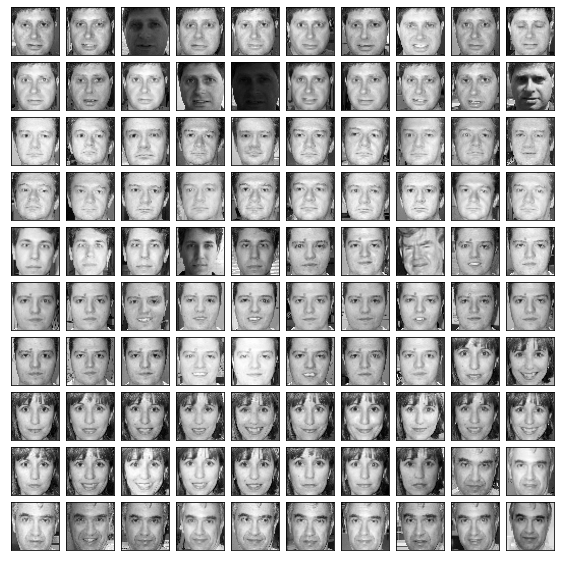

In [ ]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, faces['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## 3. Feature Extraction

Images tend to be large and can differ a lot in lighting, positioning, ... To combat this we'll extract features from each image using 4 different techniques. They all belong to the global/holistic feature representation approaches that map the image to a lower-dimensional subspace through linear and non-linear mapping. 

In [8]:
from enum import Enum
from sklearn.model_selection import train_test_split

# split data for training and testing
holdout_split = lambda X,y: train_test_split(X, y, test_size=.25, shuffle = True, 
                                             stratify = y, random_state = 22)

class FeatureDescriptor(Enum):
    LBP = 1
    PCA = 2
    LDA = 3
    DL = 4

######################################
# select the technique you want to use
DESC = FeatureDescriptor.PCA
######################################

# number of PCA/LDA components to retain
num_components = 35

In [ ]:
features_extractors = []

### 3.1. Eigenfaces for face recognition

In 1971 Goldstein et al. ([Identification of human faces](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=1450184&url=http%3A%2F%2Fieeexplore.ieee.org%2Fxpls%2Fabs_all.jsp%3Farnumber%3D1450184)) demonstrated that facial characteristics can be manually extracted, quantified and used for face recognition. The question then remained: could this be done in an automatic fashion? 

It wasn’t until the 1987 paper by Kirby and Sirovich ([A Low-Dimensional Procedure for the Characterization of Human Faces](https://gurus.pyimagesearch.com/wp-content/uploads/2015/10/kirby_1987.pdf)) that we were able to answer this question. This paper is considered to be a seminal work in the history of computer vision — and while other approaches have since been proposed that can outperform Eigenfaces, it’s still important that we take the time to understand and appreciate this algorithm. [Turk and Pentland](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjmvqy6jqfhAhWFZFAKHb74DNgQFjAAegQIABAC&url=http%3A%2F%2Fwww.face-rec.org%2Falgorithms%2Fpca%2Fjcn.pdf&usg=AOvVaw2IlxVps8dldmeA01yQDa_I) built on this idea in the context of face recognition. 

The Eigenfaces algorithm uses Principal Component Analysis to construct a low-dimensional representation of face images.

![An example of applying an eigenvalue decomposition to a dataset of faces and extracting the 16 "eigenfaces" with the largest corresponding eigenvalue magnitude.](notebook_images/what_is_fr_eigenfaces.jpg)


This involves collecting a dataset of faces with multiple face images per person we want to identify — like having multiple training examples of an image class we would want to label in image classification. Given this dataset of face images (presumed to be the same width, height, and ideally — with their eyes and facial structures aligned at the same (x, y)-coordinates, we apply an eigenvalue decomposition of the dataset, keeping the eigenvectors with the largest corresponding eigenvalues.

Given these eigenvectors, a face can then be represented as a linear combination of what Kirby and Sirovich call eigenfaces.

Face identification can be performed by computing the Euclidean distance between the eigenface representations and treating the face identification as a k-Nearest Neighbor classification problem — however, we tend to commonly apply more advanced machine learning algorithms to the eigenface representations.

Last, it’s important to note that the Eigenfaces algorithm is **not-specific to faces** — we can actually apply it to any arbitrary dataset containing objects of the same type that need to be compared, whether that may be bicycles, cans of soup, or ancient Aztec coins. The Eigenfaces algorithm can be modified to accommodate each of these identification tasks.

In [ ]:
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

# Compute a PCA (eigenfaces) on the face dataset
num_components = min(num_components, min(n_samples, n_features))
print("num_components {n}".format(n=num_components))
desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces.data)
X_pca = desc.transform(faces.data)
embedded = X_pca
# Save info in dictionary for easier retrieval later
pca_ext  = {}
pca_ext["embeddings"]  = X_pca
pca_ext["dist_metric"]  = euclidean
pca_ext["descriptor"] = "PCA"

features_extractors.append(pca_ext)


num_components 35


### 3.2. Fisherfaces for face recognition

From [Scholarpaedia](http://www.scholarpedia.org/article/Fisherfaces):
> When the goal is classification rather than representation, PCA may not yield the most desirable results. In such cases, one wishes to find a subspace that maps the sample vectors of the same class in a single spot of the feature representation and those of different classes as far apart from each other as possible. The techniques derived to achieve this goal are known as discriminant analysis (DA).
The most known DA is [Linear Discriminant Analysis (LDA)](http://www.scholarpedia.org/article/Linear_Discriminant_Analysis), which can be derived from an idea suggested by R.A. Fisher in 1936. When LDA is used to find the subspace representation of a set of face images, the resulting basis vectors defining that space are known as [Fisherfaces](http://www.scholarpedia.org/article/Fisherfaces).

![Example of FisherFaces](notebook_images/FisherFaces.jpg)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.spatial.distance import euclidean

num_components = min(num_components, min(n_samples, n_features))
desc = LinearDiscriminantAnalysis(n_components=num_components).fit(faces.data, faces.target)
X_lda = desc.fit_transform(faces.data, faces.target)
# Save info in dictionary for easier retrieval later
lda_ext  = {}
lda_ext["embeddings"]  = X_lda
lda_ext["dist_metric"]  = euclidean
lda_ext["descriptor"] = "LDA"

features_extractors.append(lda_ext)

### 3.3. LBP for face recognition

Local Binary Patterns, or LBPs for short, are a texture descriptor made popular by the work of Ojala et al. in their 2002 paper, [Multiresolution Grayscale and Rotation Invariant Texture Classification with Local Binary Patterns](http://www.outex.oulu.fi/publications/pami_02_opm.pdf) (although the concept of LBPs were introduced as early as 1993).

Unlike [Haralick texture features](http://haralick.org/journals/TexturalFeatures.pdf) that compute a global representation of texture based on the [Gray Level Co-occurrence Matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix), LBPs instead compute a local representation of texture. This local representation is constructed by comparing each pixel with its surrounding neighborhood of pixels. See [PyImageSearch](https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/) and [Scikit-Image](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html) for further details on LBP.
![LBP](notebook_images/LBP.png)

In [315]:
from local_binary_patterns import LBP
from scipy.stats import chisquare

desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
embedded = desc.describe_list(faces.images[...,0])
# Save info in dictionary for easier retrieval later
lbp_ext  = {}
lbp_ext["embeddings"]  = embedded
lbp_ext["dist_metric"]  = chisquare
lbp_ext["descriptor"] = "LBP"

features_extractors.append(lbp_ext)

### 3.4. Deep metric learning
Similar to previous techniques, we can use deep learning to generate an enriched representation of faces that you can use in simple or more complicated classification algorithms. 
Instead of building networks that are trained end-to-end to perform face recognition, we will use deep metric learning. Metric learning based methods learn a projection of the input data on a low-dimensional vector, such that classification in that lower-dimensional space is much easier and can be performed using simple distance metrics. 

In the context of face recognition we can observe the following major Deep Learning based approaches since 2014.

1. The first approach was developed and presented in 2014 by researchers at Facebook and is called [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) . The major contributions where a CDNN to classify faces. In addition a 3D/2D alignment procedure is applied prior to classification. 
The CDNN is trained as a classifier on the SFC (Social Face Classification) dataset, which is a very large (4.4 million image of 4000 individuals) dataset. This setting is called supervised.  The challenge is whether this can also be generalizd to other datasets and subjects as well. By training it on the large collection of uncontrolled images, an embedded representation (the vector description prior to the classification layer) can be generated that is, allegedly, generalizable to other face recognition data. One can then use this representation as we have previously done for classical representations. 
By way of demonstration they tested it on the LFW dataset to achieve >0.95% verification accuracy. <br> 



2. The second approach was developed by researchers at Google.  An in-depth presentation of their FaceNet/OpenFace deep CNN's for metric embedding of faces is given by [Martin Krasser et al](http://krasserm.github.io/2018/02/07/deep-face-recognition/). Note that this method was trained on 200 million images of eight million identities. The main methodological point is that these networks are trained using a special loss-function: the triplet loss function. 
>This function is minimized when the distance between an anchor image $x_{ai}$ and a positive image $x_{pi}$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x_{ni}$ (different identity) by at least a margin $\alpha$. Model training aims to learn an embedding f(x) of image x such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. 

There is a very elegant Python implementations available of the FaceNet/OpenFace approach. It is nicely described in [this PyImageSearch tutorial](https://www.pyimagesearch.com/2018/06/18/face-recognition-with-opencv-python-and-deep-learning/). It explicitly includes the Dlib package with the [face_recognition modules](https://face-recognition.readthedocs.io/en/latest/index.html) for face detection and recognition. Especially the latter package provides a very convenient interface. 

From the [Dlib face_recognition.py](https://github.com/davisking/dlib/blob/master/python_examples/face_recognition.py) code, we get an application view of the embedding:

> This example shows how to use dlib's face recognition tool.  This tool maps an image of a human face to a 128 dimensional vector space where images of the same person are near to each other and images from different people are far apart.  Therefore, you can perform face recognition by mapping faces to the 128D space and then checking if their Euclidean distance is small enough. 

> When using a distance threshold of 0.6, the dlib model obtains an accuracy of 99.38% on the standard LFW face recognition benchmark, which is comparable to other state-of-the-art methods for face recognition as of February 2017. This accuracy means that, when presented with a pair of face images, the tool will correctly identify if the pair belongs to the same person or is from different people 99.38% of the time.



#### 3.4.1 Deep Metric Learning using Siamese Networks

In the [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) paper they also tested a [siamese network](https://en.wikipedia.org/wiki/Siamese_network) DNN architecture for generating embedded vector representations.  This consists of two copies of the same CNN (sharing their weights) that are applied to pairs of images. During training the distance between the embedded representations of the same individual is minimized, and the distances between embedded representations of different individuals is maximized. In the mean time, this work was extended, steadily increasing the performance. Siamese networks are an example of *One-shot Learning* where you tyically have very few samples per object or dynamically changing number of objects/subjects. While [this link](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d) tests it on a non-face recognition task, it can be applied to face recognition as well.

The localmodules.siamese file contains the description of a shallow CNN model that is trained with [contrastive loss](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).
This subnetwork is copied twice and the output of both siamese copies are then passed onto a vector euclidean distance (ED) calculation layer. The network gets as input pairs of imposter or genuine images with the associated label (genuine = 0, imposter = 1). You can make use of the output of the network or the output before the ED layer (embedded) in your validation.

Note: this part on Siamese networks is adapted from (from [Packt tutorial](https://hub.packtpub.com/face-recognition-using-siamese-networks-tutorial/), which seems to be a re-implementation from  [this Packt book on Neural Network Projects with Python](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781789138900)). See also [this Hackernoon tutorial](https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e).

Note: you can change the CNN at your will, but beware that it might take additional training time.

In [312]:
import siamese

encoder, model = siamese.create_siamese_model(imshape)
model.summary()

Model: "model_126"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_191 (InputLayer)          [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
input_192 (InputLayer)          [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          894400      input_191[0][0]                  
                                                                 input_192[0][0]                  
__________________________________________________________________________________________________
lambda_63 (Lambda)              (None, 1)            0           sequential[1][0]         

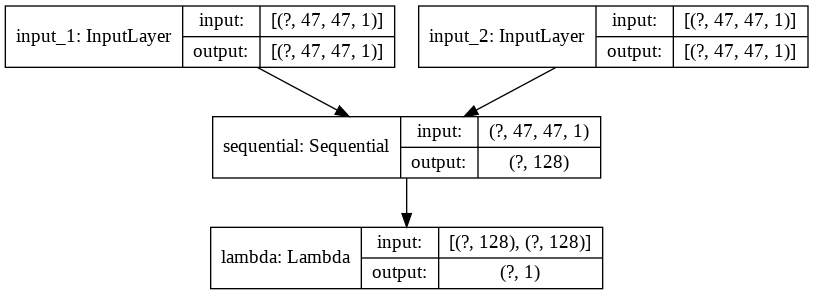

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes = True, show_layer_names = True)

Depending on the complexity of the Siamese network this might take a while. You can also change the number of epochs to improve the training (with the risk of overfitting). You will notice that a small number (<10) of epochs already gets you a decent performance.

In [313]:
from tensorflow.keras.optimizers import RMSprop, Adam

from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score

x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(faces.images, faces.target))
rms = Adam()
model.compile(
    loss=siamese.contrastive_loss, 
    optimizer=rms, 
    metrics = [siamese.accuracy])

epochs = 10
model.fit([x_train[:, 0], x_train[:, 1]], y_train, 
          validation_split=0.2,
          batch_size=32, verbose=2, epochs=epochs)

test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
test_acc = accuracy_score(y_test, test_scores > 0.5)
print("Accuracy on the test set: {}".format(test_acc))
descriptor = "DL"
embedded = encoder(faces.images.astype(float)).numpy()
# Save info in dictionary for easier retrieval later
dl_ext  = {}
dl_ext["embeddings"]  = embedded
dl_ext["dist_metric"]  = euclidean
dl_ext["descriptor"] = "Siamese"

features_extractors.append(dl_ext)

Epoch 1/10
38/38 - 1s - loss: 0.0947 - accuracy: 0.7352 - val_loss: 0.0541 - val_accuracy: 0.8802
Epoch 2/10
38/38 - 1s - loss: 0.0415 - accuracy: 0.9202 - val_loss: 0.0340 - val_accuracy: 0.9469
Epoch 3/10
38/38 - 1s - loss: 0.0237 - accuracy: 0.9729 - val_loss: 0.0252 - val_accuracy: 0.9656
Epoch 4/10
38/38 - 1s - loss: 0.0155 - accuracy: 0.9852 - val_loss: 0.0215 - val_accuracy: 0.9781
Epoch 5/10
38/38 - 1s - loss: 0.0115 - accuracy: 0.9934 - val_loss: 0.0193 - val_accuracy: 0.9812
Epoch 6/10
38/38 - 1s - loss: 0.0087 - accuracy: 0.9975 - val_loss: 0.0175 - val_accuracy: 0.9812
Epoch 7/10
38/38 - 1s - loss: 0.0070 - accuracy: 0.9975 - val_loss: 0.0157 - val_accuracy: 0.9844
Epoch 8/10
38/38 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0139 - val_accuracy: 0.9875
Epoch 9/10
38/38 - 1s - loss: 0.0045 - accuracy: 0.9992 - val_loss: 0.0128 - val_accuracy: 0.9906
Epoch 10/10
38/38 - 1s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0132 - val_accuracy: 0.9906
Accuracy on the tes

# Save extractors in file

In [ ]:
import pickle
feat_ext_file = "/gdrive/My Drive/Assigment3/extractors_v1.txt"

with open(feat_ext_file,"wb") as f:
  pickle.dump(features_extractors,f)

## 4. Classification in typical biometrics setting

#### <font color=blue> Task 1: Compute pair-wise matching scores
Given the function <em>dist_metric</em> and the vector representations in variable <em>embedded</em>, compute the pairwise distances. 

## 5. Advanced Classification Scenario
Biometrics classification is based on generating pairwise matching scores. 
* In verification mode one compares this matching score to a decision threshold in a 1-to-1 classification setting.
* In identifcation mode one uses this matching score to rank the templates in the database and, possibly, thresholding it as well in a 1-to-N classification setting

Hence, a simple pairwise comparision (L2-distance, e.g.) can be used. 

In a more general classification scenario one can use the feature representations to build more complex classifiers (SVM, NN, etc.). Testing then requires a splitting in training and validation subsets. 

Here you find an example with KNN and SVM as classifiers and their validation results. 

In [131]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Holdout on dataset
X_train_class, X_test_class, y_train_class, y_test_class = holdout_split(embedded, faces.target)

### KNN classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn.fit(X_train_class, y_train_class)

acc_knn = accuracy_score(y_test_class, knn.predict(X_test_class))
print(f'KNN accuracy = {acc_knn}')

KNN accuracy = 0.9454545454545454


## 6. Evaluation

In this section you can re-use the code you developed for validation in the previous assignments

### 6.1. Validation as verification system

In [328]:
class pair_sampler(object):
    def __init__(self,labels):
        self.labels=np.array(labels,dtype=np.int32)

    def __call__(self,query_label):
        #find id
        try:
          found_id = np.argwhere(self.labels == query_label)[0] #first occurence of label==query_label
          #set label of found_id to -1 so we can´t get this same id again
          self.labels[found_id] = -1
          return int(found_id)
        except:
          return np.nan

class Scorer(object):
    def __init__(self, features, targets, distance_metric):
      self.features = features
      #convert string ids into numerical id for each user
      self.targets = np.array(targets,dtype=np.int32)
      self.distance_metric = distance_metric

    def compute_pair_distances(self,embeddings_pair,**kwargs):
      """Task 1: Compute pairwise distances between embeddings"""
      if (self.distance_metric  == chisquare):
        # embeddings = np.array([embeddings_pair[0],embeddings_pair[1]])
        embeddings  = np.vstack(embeddings_pair)
        distance = self.distance_metric(embeddings.ravel())[0]
      else:  
        distance = self.distance_metric(*embeddings_pair,**kwargs)
      return distance

    def get_samples_info(self,idx1,idx2):
       #get samples info
        embeddings = [self.features[idx1],self.features[idx2]]
        labels = [self.targets[idx1],self.targets[idx2]]
        return embeddings, labels


    def dataset_scoring(self,normalize = True,**scoring_opts):
      """ Method to score the given dataset, given the metric_dist 
          We define the score as the inverse of the pairwise distance"""
      genuine_ids=[]
      distances=[]
      index_list = index_list = range(len(self.targets))
    
      for count,idx1 in tqdm(enumerate(index_list)):
          rest_idx = index_list[count+1:]
          for idx2 in rest_idx:
              embeddings, labels = self.get_samples_info(idx1,idx2)
              #get pairwise distances
              distance = self.compute_pair_distances(embeddings,**scoring_opts)
              #update
              distances.append(distance)
              label = 1 if labels[0]==labels[1] else 0
              genuine_ids.append(label) 

      distances = np.array(distances,dtype=np.float32)
      scores = 1./distances

      if(normalize):
        #Normalize scores if specified
        scaler=MinMaxScaler().fit(scores.reshape(-1,1))
        scores=scaler.transform(scores.reshape(-1,1)).flatten()
      genuine_ids = np.array(genuine_ids,dtype=np.int32)

      return scores, genuine_ids

    def _compute_similarity_tensor(self,**scoring_opts):  
        #init sampler
        sampler = pair_sampler(self.targets)
        #get users idx
        users=set(self.targets)
        enrollees=users
        users_idx=[sampler(user) for user in users]
        
        #init tensor
        img_per_class = [len(self.targets[self.targets == user]) for user in users]

        batch_size  = max(img_per_class)
        similarity_tensor = np.empty([batch_size - 1,len(users),len(users)])

        for batch_id in tqdm(range(batch_size - 1)):
            for enrollee in enrollees:
                #sample enrrolee id
                enrollee_id = sampler(enrollee)
                for user_id,user in zip(users_idx,users):
                    # get pair info
                    if(not(np.isnan(enrollee_id))):
                      embeddings, labels = self.get_samples_info(user_id,enrollee_id)
                      #get scores (inverse of pairwise distances)
                      distance = self.compute_pair_distances(embeddings,**scoring_opts)
                      score = 1/ distance
                    else:
                      score = np.nan
                    #fill tensor
                    #users,enrrolees in {1,10} --> index == user -1
                    similarity_tensor[batch_id,user-1,enrollee-1] = score
        return similarity_tensor,users,enrollees
      
    def construct_similarity_matrix(self,agg_fcn,**kwargs):
        #get similarity tensor
        similarity_tensor,users,enrrollees = self._compute_similarity_tensor()
        # get similarity matrix after aggragation transformation given by agg_fcn
        similarity_matrix = agg_fcn(similarity_tensor,**kwargs)
        # set index and columns (users,enrrolees)
        similarity_matrix = pd.DataFrame(similarity_matrix,index=users,columns=enrrollees)
        return similarity_matrix

#### <font color=blue> Task 2: Compute F1 and accuracy scores for variable (and optimal) thresholds

* Calculate and plot F1 and accuracy scores for a range (min, max) of thresholds.
* Determine some optimal threshold (look up in classification literature)

In [ ]:
metric_logger=Metrics(scores,genuine_ids,"Validation")
"""Plot F1 and accuracy as a function of the decision thresholds on the similarity score."""
metrics_dict={
    "f1":f1_score,
    "Accuracy":accuracy_score
}

In [ ]:
_,ax=plt.subplots(1,1)
metric_logger.plot_metric(ax,"f1",metrics_dict)
plt.show()

In [ ]:
_,ax=plt.subplots(1,1)
metric_logger.plot_metric(ax,"Accuracy",metrics_dict)
plt.show()

#### <font color=blue> Task 3: Plot genuine and impostor scores

In [133]:
def plot_joint_dist(scores,labels):
    scores_gen = scores[labels == 1]
    scores_imp = scores[labels != 1]
    plt.hist(scores_gen,density=True,label="genuine dist")
    plt.hist(scores_imp,density=True,label="impostor dist")
    plt.legend()
    plt.title(f"Score Distributions {descriptor}")
    plt.show()

In [ ]:
plot_joint_dist(scores,genuine_ids)

#### <font color=blue> Task 4: Calculate Equal Error Rate

> Indented block



In [ ]:
metric_logger.get_roc_metrics()
fpr_eer,tpr_eer=metric_logger.compute_eer_point()

#### <font color=blue> Task 5: Calculate classification scores
* plot precision-recall curve
* calculate AUC
* average precision

In [ ]:
_,ax=plt.subplots(1,1)
metric_logger.plot_pr_curve(ax)
plt.show()

In [ ]:
"""Calculate the average precision scores"""
from sklearn.metrics import average_precision_score
print(f"Ap = {metric_logger._get_metric(average_precision_score):.2f}")

In [ ]:
_,ax=plt.subplots(1,1)
metric_logger.plot_roc_curve(ax)
plt.show()

## 6.2 Validation as identification system

#### <font color=blue> Task 6: Generate a Cumulative Matching Curve

In [ ]:
agg_fcn = np.nanmean
fcn_args ={"axis" : 0}
similarity_matrix=scorer.construct_similarity_matrix(agg_fcn,**fcn_args)
#cmc
cmc_obj=CMC(similarity_matrix)
_,ax=plt.subplots(1,1)
cmc_obj.plot_CMC_curve(ax)
plt.show()

## 6.2 Validation in multi-classification setting
#### <font color=blue> Task 7: Validate the advanced classification scenario
You can choose an appropriate metric. 

# Confusion Matrix

In [134]:
def plot_confusion_matrix(true_labels,predicted_labels,title=""):
  n_classes = len(set(true_labels))
  cnf_matrix = confusion_matrix(true_labels, 
                                      predicted_labels,labels=range(n_classes))
  cnf_matrix= cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
  df = pd.DataFrame(cnf_matrix,range(n_classes),range(n_classes))
  _, ax = plt.subplots(1, figsize=(12, 8))
  sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})
  sns.heatmap(df,cmap ="Oranges", annot=True) 
  plt.title(title)
  plt.show()

In [ ]:
plot_confusion_matrix(y_test_class,predicted_labels, title="Normalized Confussion Matrix")

# Visual exploration of Embeddings (Umap)

In [135]:
def visualize_embeddings_umap(embeddings, labels, title = "", **umap_kwargs):
    n_classes = len(set(labels))
    #Init umapper
    umapper = umap.UMAP(**umap_kwargs) 
    # Compute umap embeddings
    umap_embeddings = umapper.fit_transform(embeddings)
    # Plot embeddings
    with sns.plotting_context(context="poster"):
      with sns.axes_style("white"):
          _, ax = plt.subplots(1, figsize=(12, 8))
          plt.scatter(*umap_embeddings.T, s=2, c= labels, cmap= "tab20b", alpha=1)
          plt.setp(ax, xticks=[], yticks=[])
          cbar = plt.colorbar(boundaries=np.arange(n_classes+1)-0.5)
          cbar.set_ticks(np.arange(n_classes))
          cbar.set_ticklabels(range(n_classes))
          plt.title(title)

In [ ]:
visualize_embeddings_umap(embedded,faces.target)

# Matthews correlation coefficient (MCC)


In [ ]:
metric_logger=Metrics(X_test,y_test,"Verification")
mcc  = metric_logger._get_metric(matthews_corrcoef)

0.943129694150888

## 7. Task
All tasks should be accompanied by a text providing information on; the technique, the steps, and, the reasoning behind choosing the techniques.

<em>Note: in case you find yourself needing extra computational power you can make use of [google colab](https://colab.research.google.com/). However, implementing overly complicated routines is discouraged. </em>

### 7.1. Mandatory tasks
<b>The student should do all of the tasks indicated below</b>: 
1. Execute all the tasks indicated in the document above
2. Compare the 4 feature representations (LBP, PCA, LDA, DL using Siamese Networks) using the implemented validation metrics and report on the performance below (you can for instance store your intermediary results/plots in a file and plot them below).

# Comparison of given Feature Representations

In [136]:
def plt_compare_metrics(systems,plot_fcn,**kwargs):
    """DOCUMENT THIS"""
    n_systems = len(systems)
    _, axs = plt.subplots(1, n_systems, figsize=(25,10))

    for ax,system in zip(axs,systems):
        getattr(system,plot_fcn)(ax,**kwargs)

    plt.show()

In [331]:
def get_validation_loggers(features_extractors):
  loggers = []
  cmcs = []
  agg_fcn = np.nanmean
  fcn_args ={"axis" : 0}
  for extractor in features_extractors:
    # Compute scores
    scorer = Scorer(extractor["embeddings"],faces.target,extractor["dist_metric"])
    scores, genuine_ids = scorer.dataset_scoring()
    #cmcs
    similarity_matrix=scorer.construct_similarity_matrix(agg_fcn,**fcn_args)
    #cmc
    cmcs.append(CMC(similarity_matrix,name = extractor["descriptor"]))
    #create logger
    metric_logger=Metrics(scores,genuine_ids,extractor["descriptor"])
    loggers.append(metric_logger)
  return features_extractors,loggers,cmcs

In [ ]:
features_extractors,loggers,cmcs = get_validation_loggers(features_extractors)

# Score Distributions

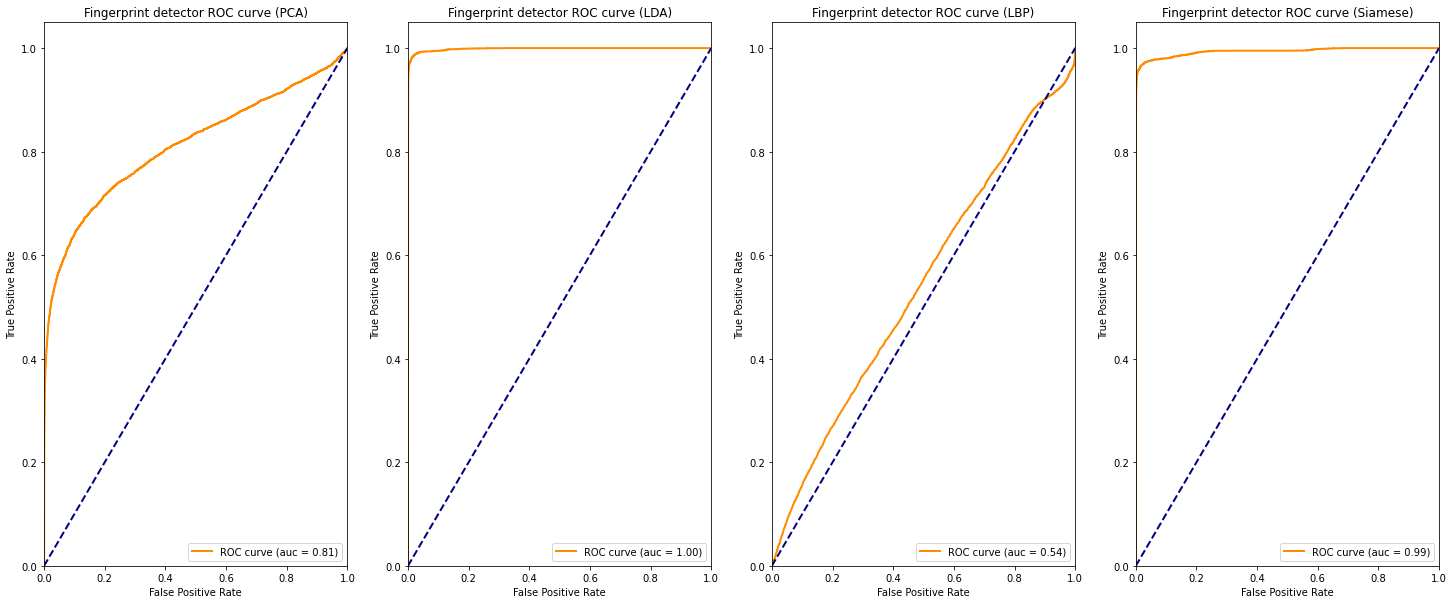

In [ ]:
#Test comparative plot
plt_compare_metrics(loggers,"plot_roc_curve")

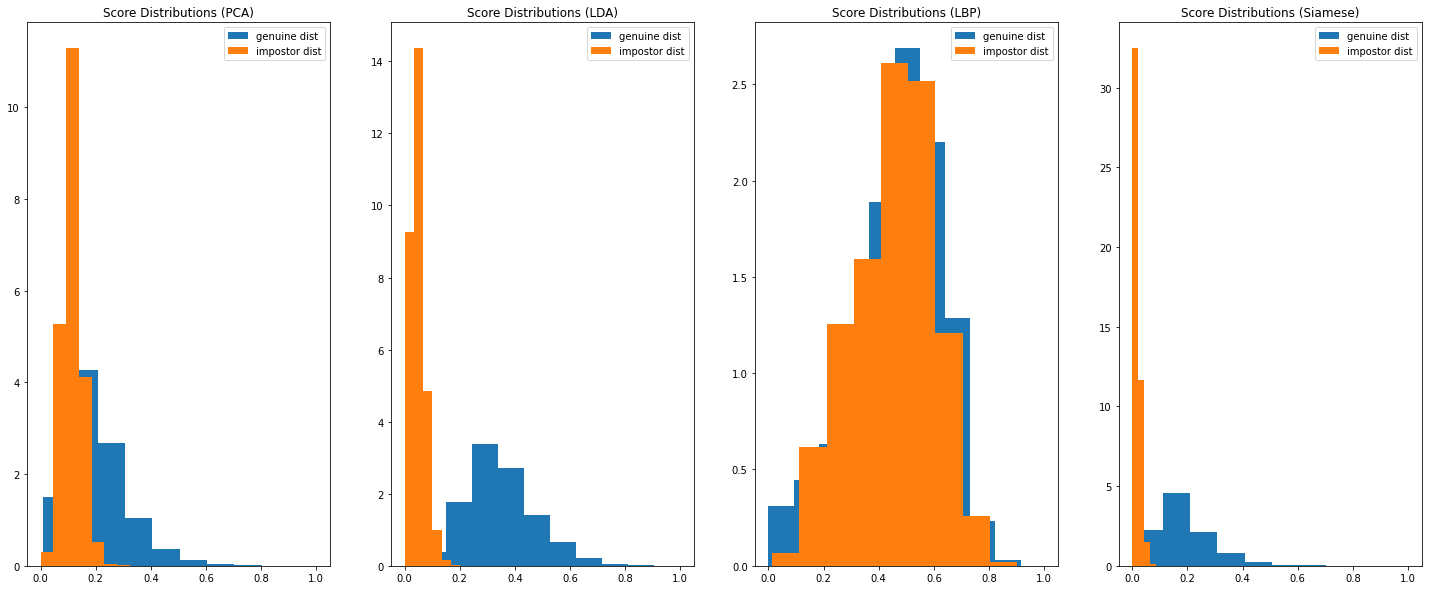

In [ ]:
plt_compare_metrics(loggers,"plot_joint_dist")


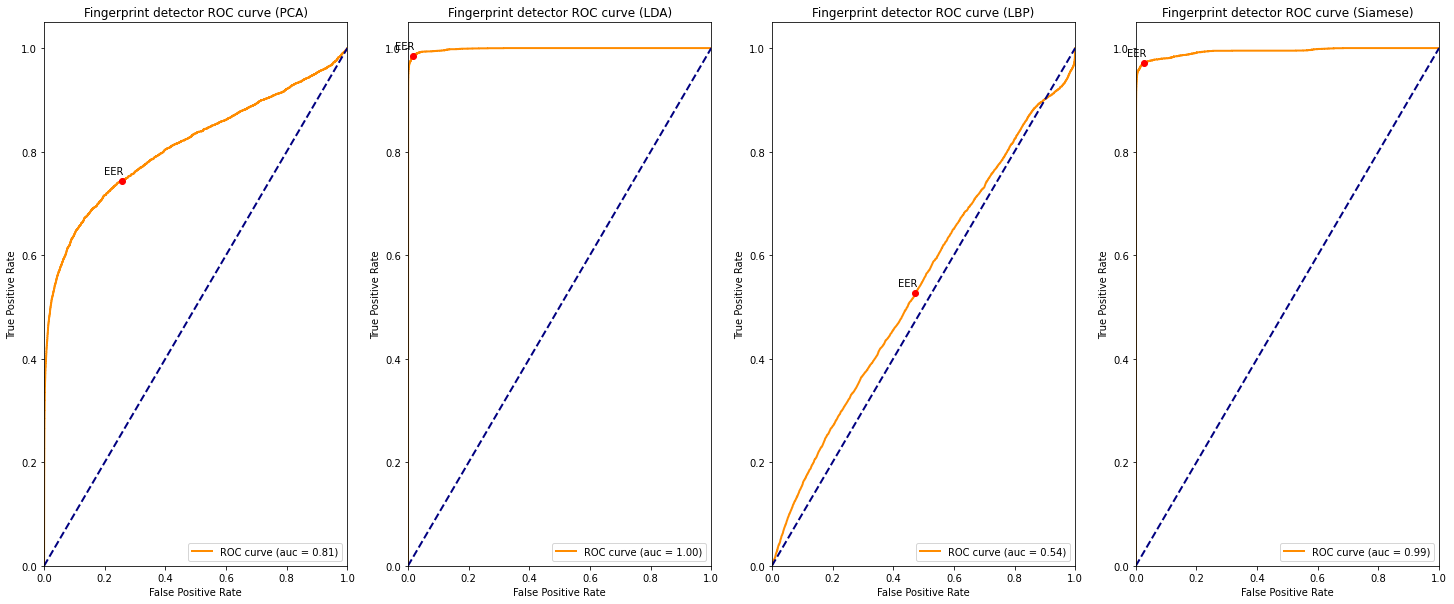

In [ ]:
opt={"point":"EER"}
plt_compare_metrics(loggers,"plot_roc_curve",**opt)

In [ ]:
metrics_dict={
            "f1":f1_score,
            "Accuracy":accuracy_score
        }

opt={"metrics_dict":metrics_dict}
opt["metric"]="f1"

  6%|▌         | 3/50 [00:00<00:02, 21.36it/s]

Optimal f1 value = 0.52 given at threshold 0.20


  6%|▌         | 3/50 [00:00<00:02, 22.72it/s]

Optimal f1 value = 0.96 given at threshold 0.16


  6%|▌         | 3/50 [00:00<00:02, 22.25it/s]

Optimal f1 value = 0.10 given at threshold 0.59


100%|██████████| 50/50 [00:02<00:00, 22.30it/s]


Optimal f1 value = 0.93 given at threshold 0.08


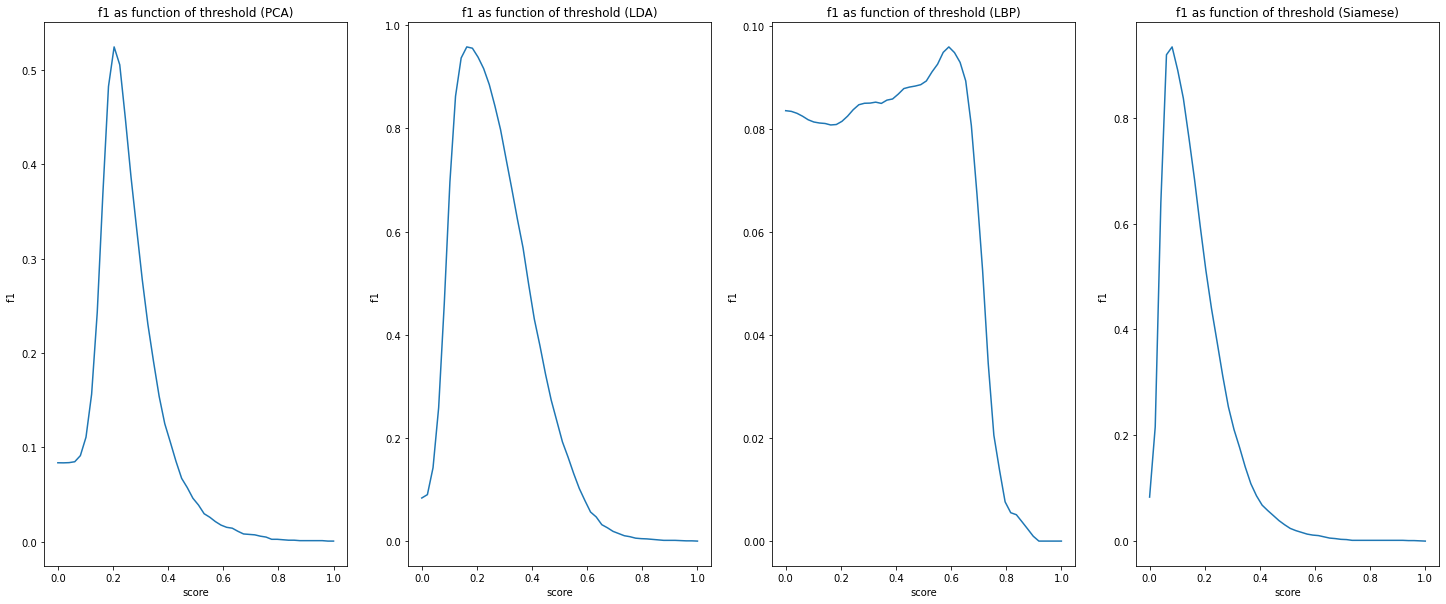

In [ ]:
plt_compare_metrics(loggers,"plot_metric",**opt)


Optimal Accuracy value = 0.97 given at threshold 0.22
Optimal Accuracy value = 1.00 given at threshold 0.16
Optimal Accuracy value = 0.96 given at threshold 1.00
Optimal Accuracy value = 0.99 given at threshold 0.08


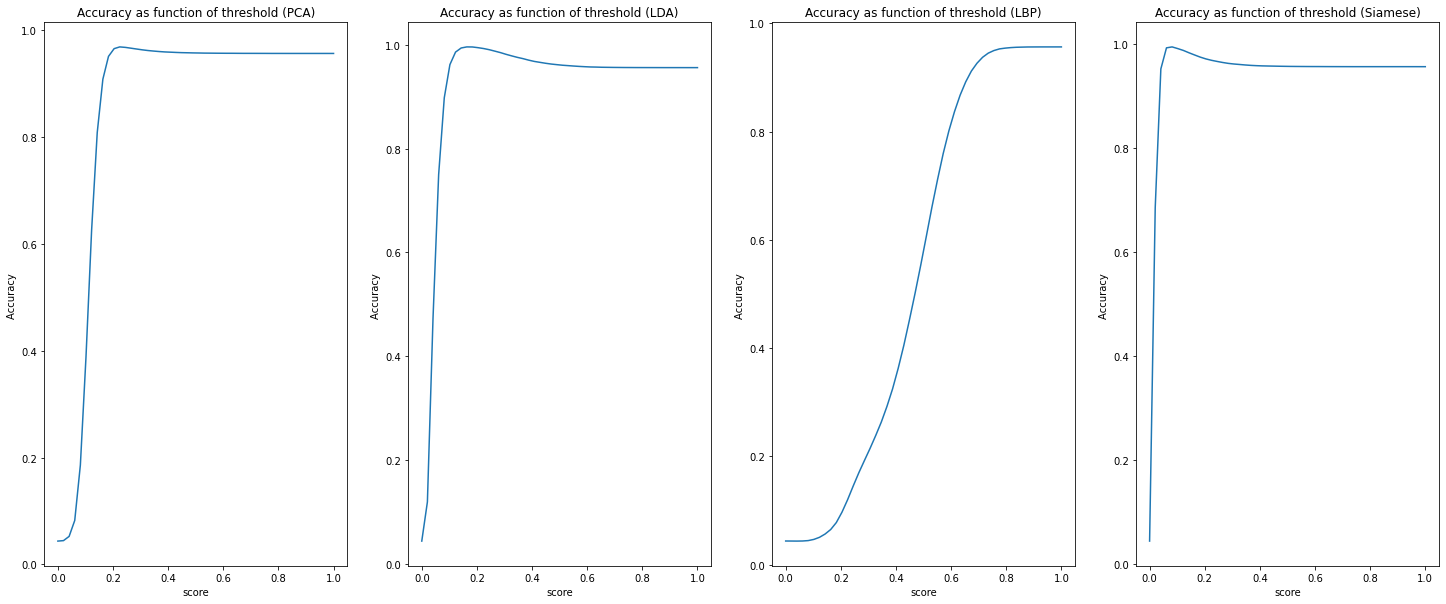

In [ ]:
opt["metric"]="Accuracy"
plt_compare_metrics(loggers,"plot_metric",**opt)

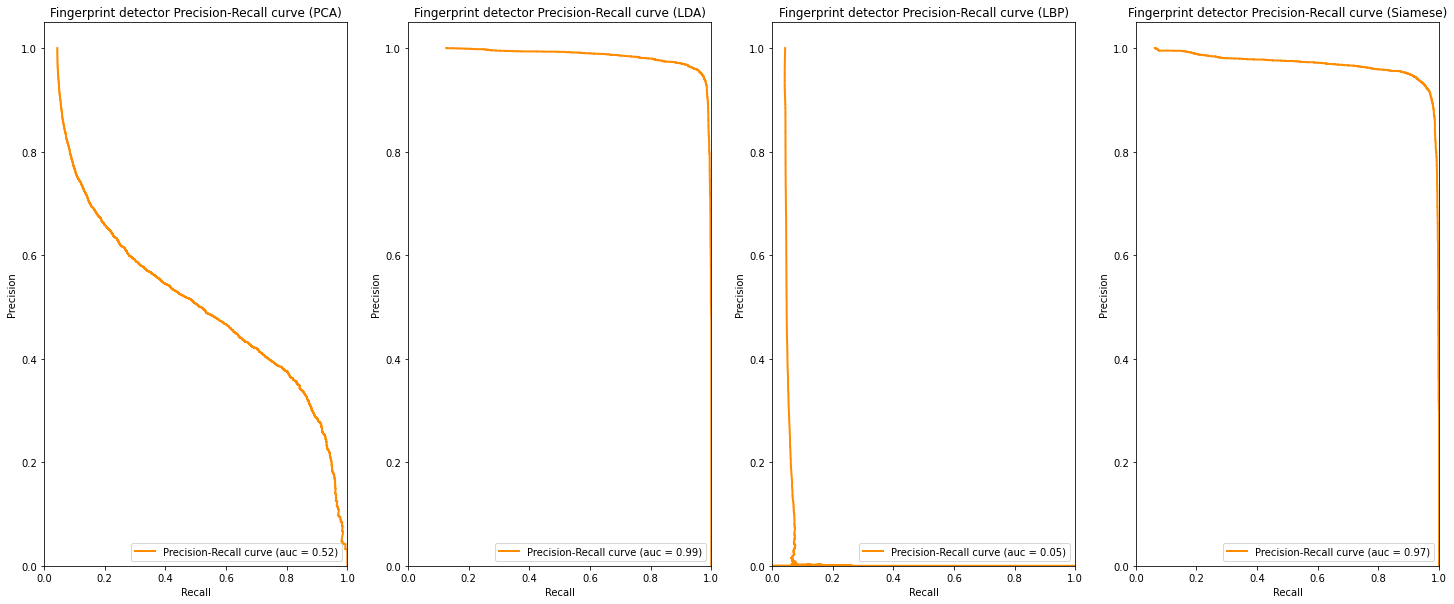

In [ ]:
plt_compare_metrics(loggers,"plot_pr_curve")

100%|██████████| 26/26 [00:00<00:00, 1502.84it/s]


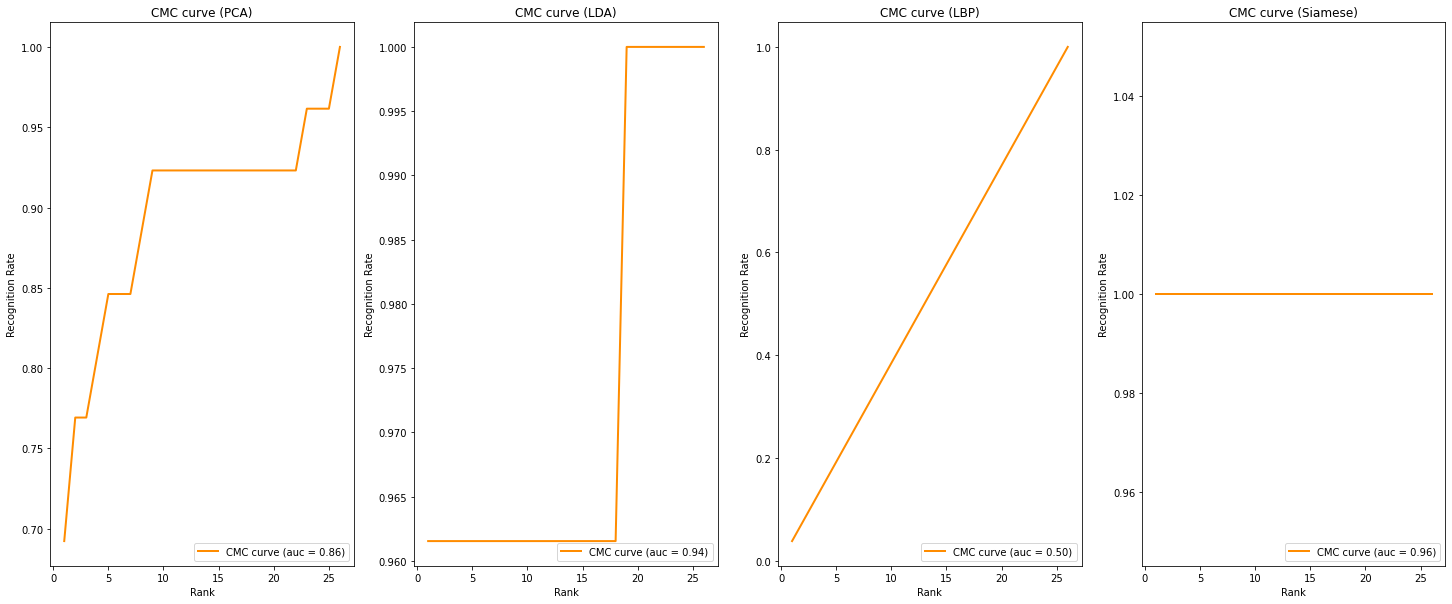

In [ ]:
plt_compare_metrics(cmcs,"plot_CMC_curve")

# Advanced Classification Scenario

In [325]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def get_classifiers(features_extractors):
  for extractor in features_extractors:
    # Holdout on dataset
    X_train_class, X_test_class, y_train_class, y_test_class = holdout_split(extractor["embeddings"], faces.target)
    knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    knn.fit(X_train_class, y_train_class)
    predicted_labels = knn.predict(X_test_class)
    acc_knn = accuracy_score(y_test_class, predicted_labels)
    mcc_knn = matthews_corrcoef(y_test_class, predicted_labels)
    print(f'KNN results of {extractor["descriptor"]} : Accuracy = {acc_knn}, MCC = {mcc_knn}')
    #save data
    extractor["true_labels"] =  y_test_class
    extractor["predicted_labels"]  = predicted_labels
  return features_extractors
  

In [ ]:
features_extractors = get_classifiers(features_extractors)

In [138]:
def find_extractor(descriptor):
  try:
    return  next(extractor for extractor in features_extractors  if extractor["descriptor"] == descriptor)
  except:
    print(f"The descriptor {descriptor} doesn't exist, check the name or whether is defined")

# PCA

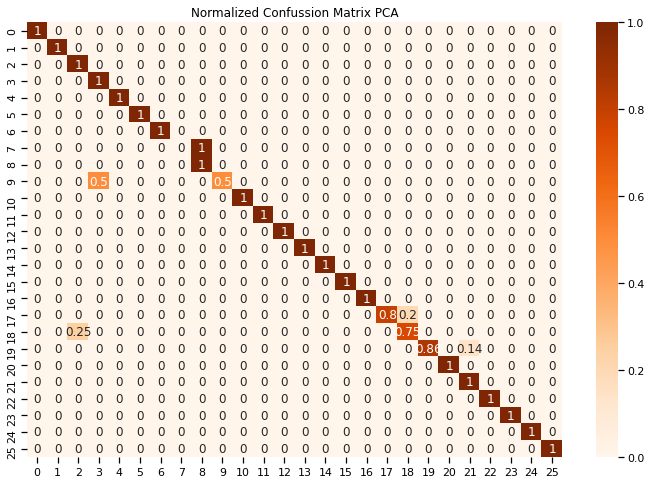

In [ ]:
pca_extractor = find_extractor("PCA")
plot_confusion_matrix(pca_extractor["true_labels"], 
                      pca_extractor["predicted_labels"],
                      title="Normalized Confussion Matrix {}".format(pca_extractor["descriptor"]))

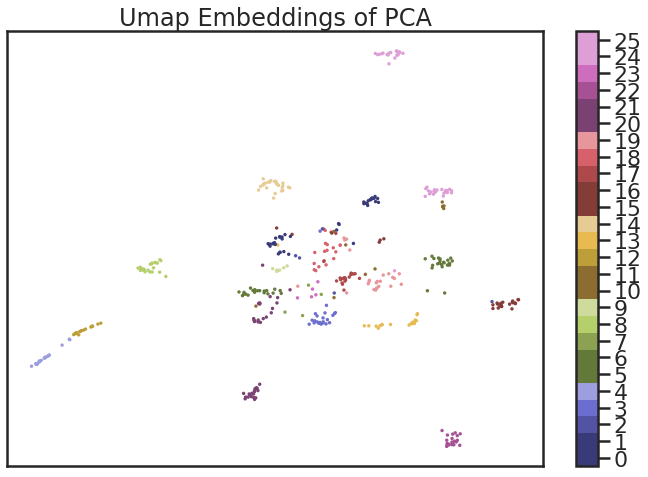

In [ ]:
visualize_embeddings_umap(pca_extractor["embeddings"],faces.target,title  = "Umap Embeddings of {}".format(pca_extractor["descriptor"]))

# LDA

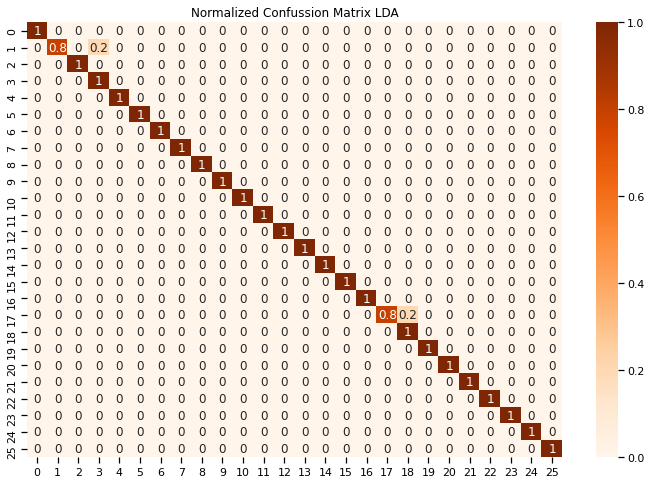

In [ ]:
lda_extractor = find_extractor("LDA")
plot_confusion_matrix(lda_extractor["true_labels"], 
                      lda_extractor["predicted_labels"],
                      title="Normalized Confussion Matrix {}".format(lda_extractor["descriptor"]))

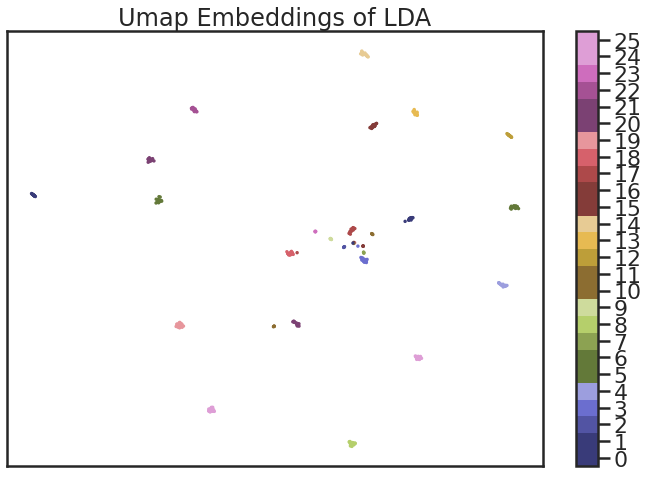

In [ ]:
visualize_embeddings_umap(lda_extractor["embeddings"],faces.target,title  = "Umap Embeddings of {}".format(lda_extractor["descriptor"]))

# LBP

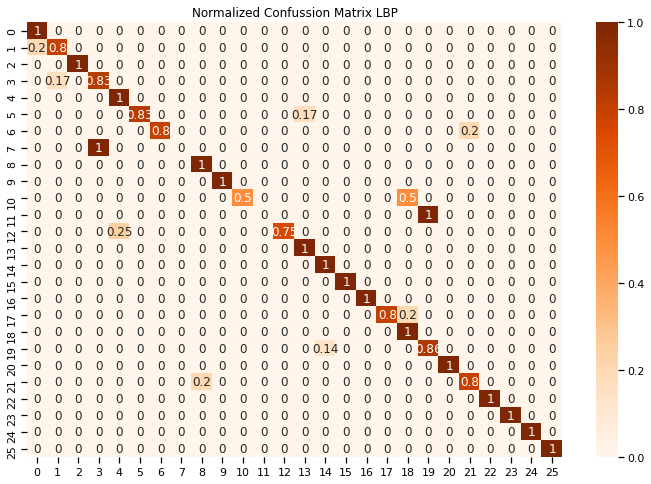

In [ ]:
lbp_extractor = find_extractor("LBP")
plot_confusion_matrix(lbp_extractor["true_labels"], 
                      lbp_extractor["predicted_labels"],
                      title="Normalized Confussion Matrix {}".format(lbp_extractor["descriptor"]))

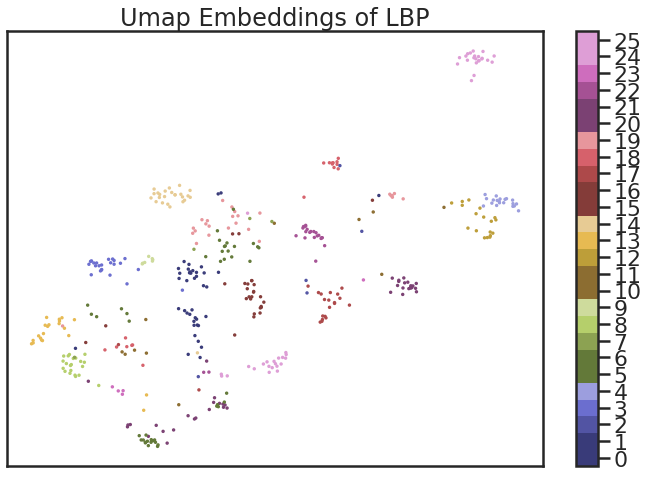

In [ ]:
visualize_embeddings_umap(lbp_extractor["embeddings"],faces.target,title  = "Umap Embeddings of {}".format(lbp_extractor["descriptor"]))

# Siamese

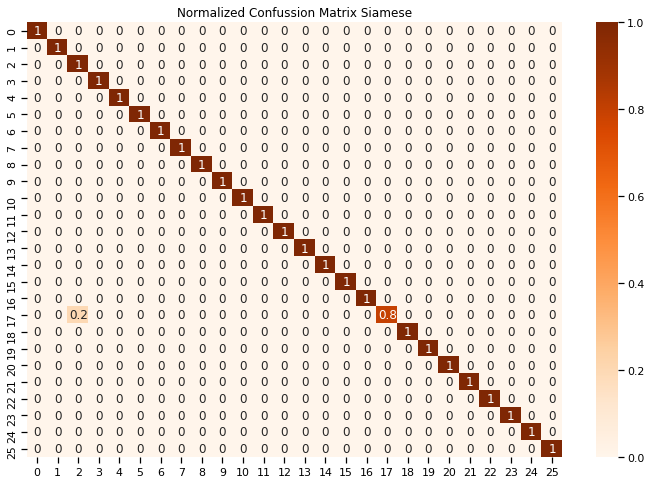

In [ ]:
siamese_extractor = find_extractor("Siamese")
plot_confusion_matrix(siamese_extractor["true_labels"], 
                      siamese_extractor["predicted_labels"],
                      title="Normalized Confussion Matrix {}".format(siamese_extractor["descriptor"]))

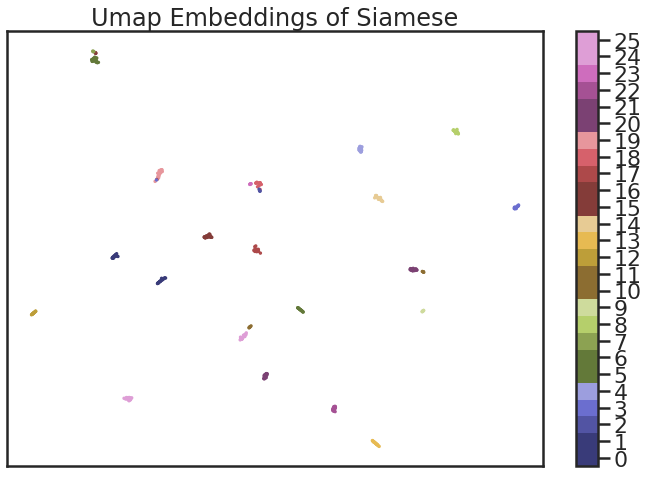

In [ ]:
visualize_embeddings_umap(siamese_extractor["embeddings"],faces.target,title  = "Umap Embeddings of {}".format(siamese_extractor["descriptor"]))

### 7.2. Tasks of choice

<b>The student should choose a number of tasks equivalent to <u>at least 3pts</u> from the list below (pts are not related to the grades)</b>. 

1. Evaluate your system on the other two datasets (AT&T, LFW) (1pt.)
2. Implement 2 different face detectors and compare all techniques to the to the ground truth bounding boxes provided in <em>CalTechFacesDirs/ImageData.mat</em>. (1pt.)
3. Develop a new advanced classifier (beyond KNN) and compare the results with the current KNN classifier. (1pt.)
4. Experiment with the Siamese deep learning model by implementing a different loss function or a different distance calculation layer. (1pt.)
5. Pre-train your deep learning network on a different (larger) dataset and compare the results. (1pt.) 
6. Implement a different deep learning model* (2pt.)

e.g. performing task 6 and 5 is valid because their points sum up to 3. 

<em>Note: Indicate clearly which tasks you end up choosing and where we can find the implementations and/or results. </em>

[*] The implemented network has to be significantly different, adding some layers like batch normalisation, dropout, ... to the current network or increasing the kernel size, amount of filters, activation functions does not count.

# Task 7.2.3 (Siamese Embeddings + LDA + Random Forest)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np

In [ ]:
extractor = find_extractor("Siamese")
X_train, X_test, y_train, y_test = holdout_split(extractor["embeddings"], faces.target)

In [ ]:
lda = LinearDiscriminantAnalysis()
rf_clf = RandomForestClassifier() 
classification_pipe = Pipeline([('lda_embedding', lda), ('rf', rf_clf)])

In [ ]:
param_grid = dict(lda_embedding__n_components=[5,20,50,100],
                 rf__n_estimators =[5, 10, 15, 20],
                 rf__max_depth =  [2, 5, 7, 9])
             
grid_clf = GridSearchCV(classification_pipe, param_grid, cv=10,scoring= scorer_mcc )
grid_clf.fit(X_train, y_train)

In [ ]:
grid_clf.best_params_

{'lda_embedding__n_components': 100,
 'rf__max_depth': 9,
 'rf__n_estimators': 20}

In [ ]:
lda = LinearDiscriminantAnalysis(n_components= 100)
rf_clf = RandomForestClassifier(max_depth= 9, n_estimators= 20) 
classification_pipe = Pipeline([('lda_embedding', lda), ('rf', rf_clf)])

In [ ]:
classification_pipe.fit(X_train,y_train)

In [ ]:
predicted_labels = classification_pipe.predict(X_test)
acc_pipeline = accuracy_score(y_test_class, predicted_labels)
mcc_pipeline = matthews_corrcoef(y_test_class, predicted_labels)
print(f'Pipeline results of {extractor["descriptor"]} : Accuracy = {acc_pipeline}, MCC = {mcc_pipeline}')

Pipeline results of Siamese : Accuracy = 1.0, MCC = 1.0


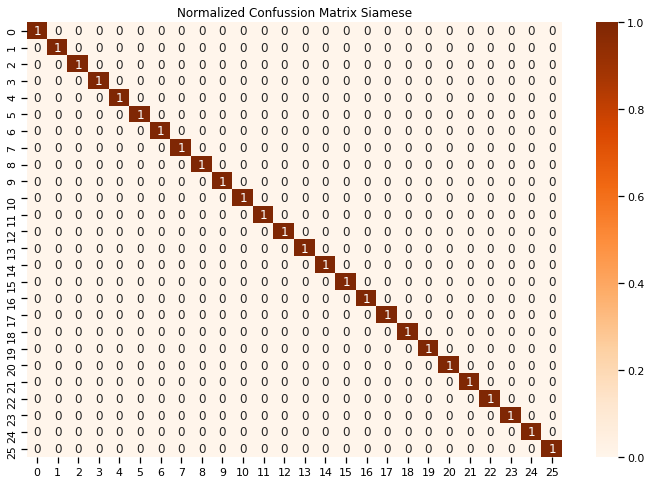

In [ ]:
plot_confusion_matrix(y_test, 
                      predicted_labels,
                      title="Normalized Confussion Matrix {}".format(siamese_extractor["descriptor"]))

# Task 7.2.6 Improving Network Architecture

In [258]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Conv2D, Input, GlobalAveragePooling2D,Activation, Add
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import MaxPooling2D, Lambda, Flatten, Dense, BatchNormalization
from tensorflow.keras import backend as K
from keras.activations import relu, softmax
from keras import regularizers

def block(n_output, upscale=False):
    # n_output: number of feature maps in the block
    # upscale: should we use the 1x1 conv2d mapping for shortcut or not
    
    # keras functional api: return the function of type
    # Tensor -> Tensor
    def f(x):
        
        # H_l(x):
        # first pre-activation
        h = BatchNormalization()(x)
        h = Activation(relu)(h)
        # first convolution
        h = Conv2D(kernel_size=3, filters=n_output, strides=1, padding='same',kernel_regularizer=regularizers.l2(1e-5))(h)
        
        # second pre-activation
        h = BatchNormalization()(x)
        h = Activation(relu)(h)
        # second convolution
        h = Conv2D(kernel_size=3, filters=n_output, strides=1, padding='same',kernel_regularizer=regularizers.l2(1e-5))(h)
        
        # f(x):
        if upscale:
            # 1x1 conv2d
            f = Conv2D(kernel_size=1, filters=n_output, strides=1, padding='same',kernel_regularizer=regularizers.l2(1e-5))(x)
        else:
            # identity
            f = x
        
        # F_l(x) = f(x) + H_l(x):
        return Add()([f,h])
    
    return f

In [306]:
def create_shared_network(input_shape):
  input_tensor = Input(input_shape)

  # first conv2d with post-activation to transform the input data to some reasonable form
  x = Conv2D(kernel_size=3, filters=16, strides=1, padding='same',kernel_regularizer=regularizers.l2(1e-5))(input_tensor)
  x = BatchNormalization()(x)
  x = Activation(relu)(x)

 
  # # F_1
  x = block(32,upscale=True)(x)
  # # F_2
  x = block(64,upscale=True)(x)
  # # F_3
  x = block(128,upscale=True)(x)

  # last activation of the entire network's output
  x = BatchNormalization()(x)
  x = Activation(relu)(x)

  # average pooling across the channels
  x = GlobalAveragePooling2D()(x)
  model = Model(inputs=input_tensor, outputs=x)
  return model

In [339]:
imshape = (47,47,1)

encoder, model = siamese.create_siamese_model(imshape)
model.summary()

Model: "model_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_194 (InputLayer)          [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
input_195 (InputLayer)          [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
model_127 (Model)               (None, 128)          109152      input_194[0][0]                  
                                                                 input_195[0][0]                  
__________________________________________________________________________________________________
lambda_64 (Lambda)              (None, 1)            0           model_127[1][0]          

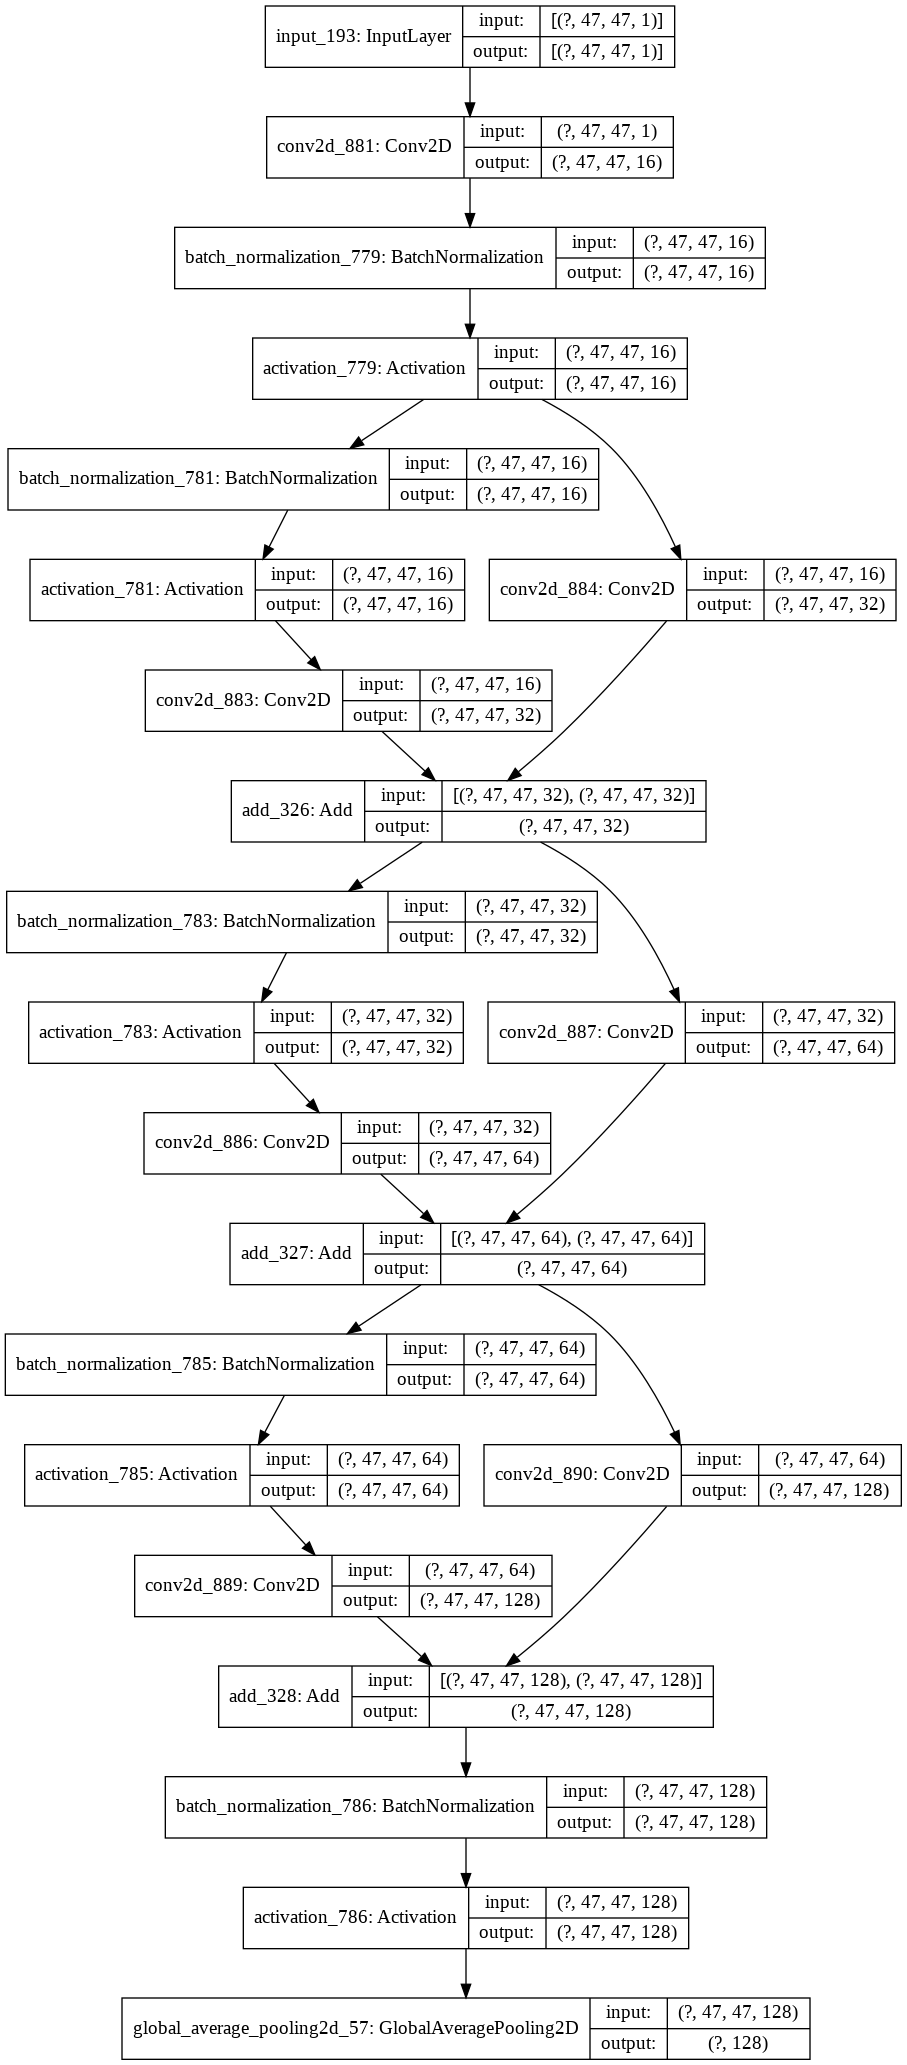

In [340]:
from tensorflow.keras.utils import plot_model
plot_model(encoder, to_file='model.png', show_shapes = True, show_layer_names = True)

In [165]:
class StepDecay():
	def __init__(self, initAlpha=0.01, factor=0.25, dropEvery=10):
		# store the base initial learning rate, drop factor, and
		# epochs to drop every
		self.initAlpha = initAlpha
		self.factor = factor
		self.dropEvery = dropEvery
	def __call__(self, epoch):
		# compute the learning rate for the current epoch
		exp = np.floor((1 + epoch) / self.dropEvery)
		alpha = self.initAlpha * (self.factor ** exp)
		return float(alpha) if alpha >=5e-5 else 5e-5


In [308]:
from keras.callbacks import LearningRateScheduler
lr_scheduler  = StepDecay(initAlpha=0.0025,factor = 0.5,dropEvery=15)
callbacks = [
    keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0),
    tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=25,
    verbose=2,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
]

In [309]:
from tensorflow.keras.optimizers import RMSprop, Adam

from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score
import siamese
x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(faces.images, faces.target))
rms = Adam()
model.compile(
    loss=siamese.contrastive_loss, 
    optimizer=rms, 
    metrics = [siamese.accuracy])

epochs = 100
model.fit([x_train[:, 0], x_train[:, 1]], y_train, 
          validation_split=0.2,
          batch_size=8, verbose=2, epochs=epochs,callbacks  = callbacks)

test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
test_acc = accuracy_score(y_test, test_scores > 0.5)
print("Accuracy on the test set: {}".format(test_acc))
embedded = encoder(faces.images.astype(float)).numpy()
# Save info in dictionary for easier retrieval later
dl_ext  = {}
dl_ext["embeddings"]  = embedded
dl_ext["dist_metric"]  = euclidean
dl_ext["descriptor"] = "SiameseResnet"

Epoch 1/100
150/150 - 3s - loss: 0.1236 - accuracy: 0.6858 - val_loss: 0.1658 - val_accuracy: 0.5461 - lr: 0.0025
Epoch 2/100
150/150 - 3s - loss: 0.1091 - accuracy: 0.6983 - val_loss: 0.1002 - val_accuracy: 0.7072 - lr: 0.0025
Epoch 3/100
150/150 - 3s - loss: 0.1031 - accuracy: 0.7117 - val_loss: 0.0816 - val_accuracy: 0.8158 - lr: 0.0025
Epoch 4/100
150/150 - 3s - loss: 0.0951 - accuracy: 0.7400 - val_loss: 0.1101 - val_accuracy: 0.7599 - lr: 0.0025
Epoch 5/100
150/150 - 3s - loss: 0.0907 - accuracy: 0.7608 - val_loss: 0.1438 - val_accuracy: 0.7039 - lr: 0.0025
Epoch 6/100
150/150 - 3s - loss: 0.0924 - accuracy: 0.7425 - val_loss: 0.0809 - val_accuracy: 0.8224 - lr: 0.0025
Epoch 7/100
150/150 - 3s - loss: 0.0863 - accuracy: 0.7800 - val_loss: 0.0965 - val_accuracy: 0.8026 - lr: 0.0025
Epoch 8/100
150/150 - 3s - loss: 0.0846 - accuracy: 0.7825 - val_loss: 0.0795 - val_accuracy: 0.8322 - lr: 0.0025
Epoch 9/100
150/150 - 3s - loss: 0.0804 - accuracy: 0.7942 - val_loss: 0.1025 - val_accu

# Score Distributions

In [ ]:
features_extractors,loggers,cmcs = get_validation_loggers(features_extractors)

440it [00:01, 405.95it/s]
100%|██████████| 25/25 [00:00<00:00, 102.54it/s]
440it [00:01, 439.67it/s]
100%|██████████| 25/25 [00:00<00:00, 101.11it/s]


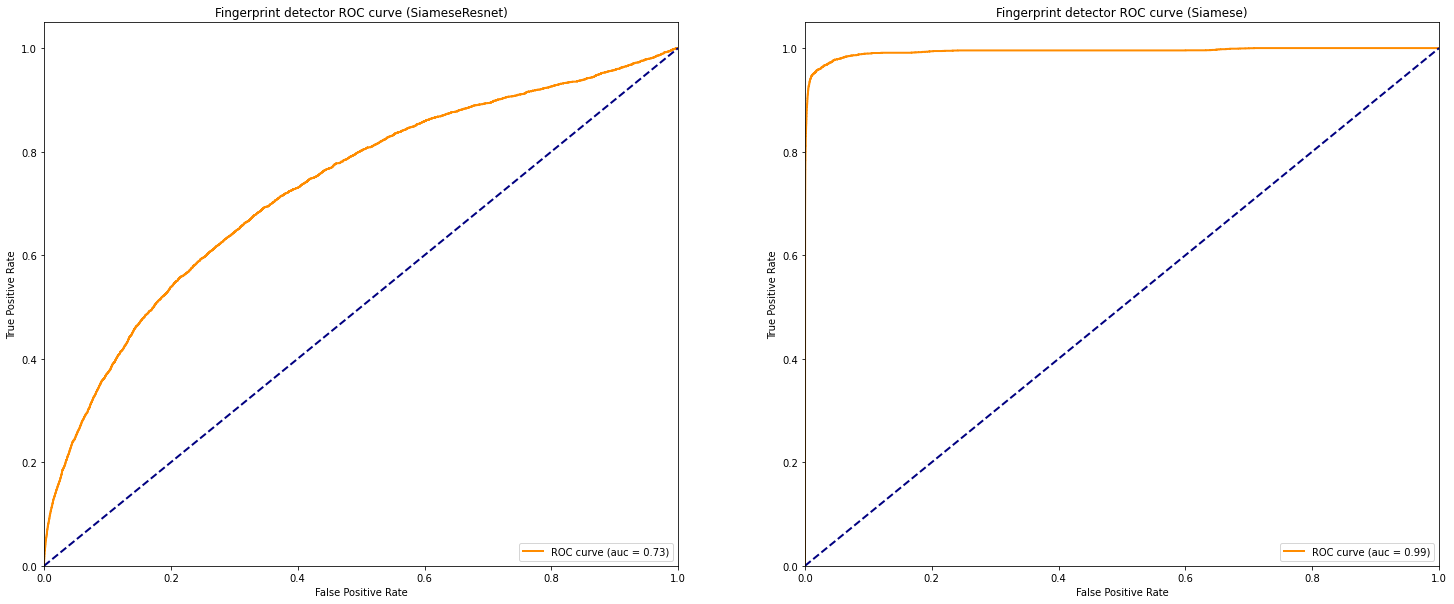

In [333]:
#Test comparative plot
plt_compare_metrics(loggers,"plot_roc_curve")

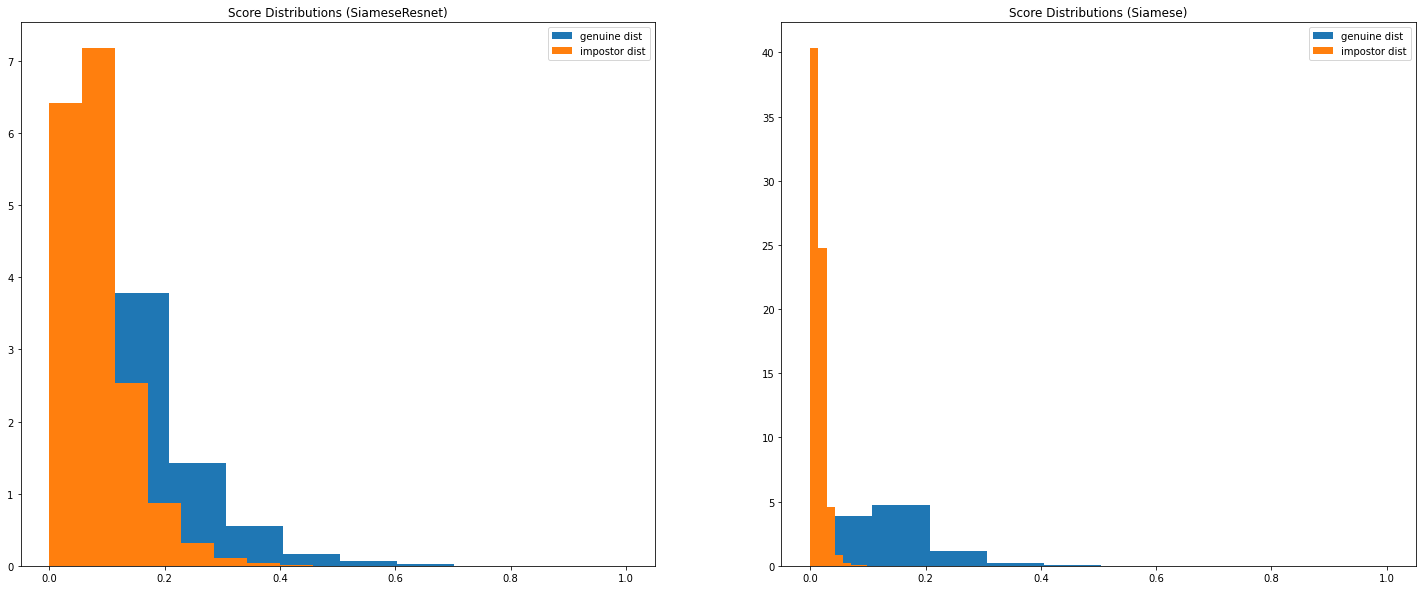

In [318]:
plt_compare_metrics(loggers,"plot_joint_dist")


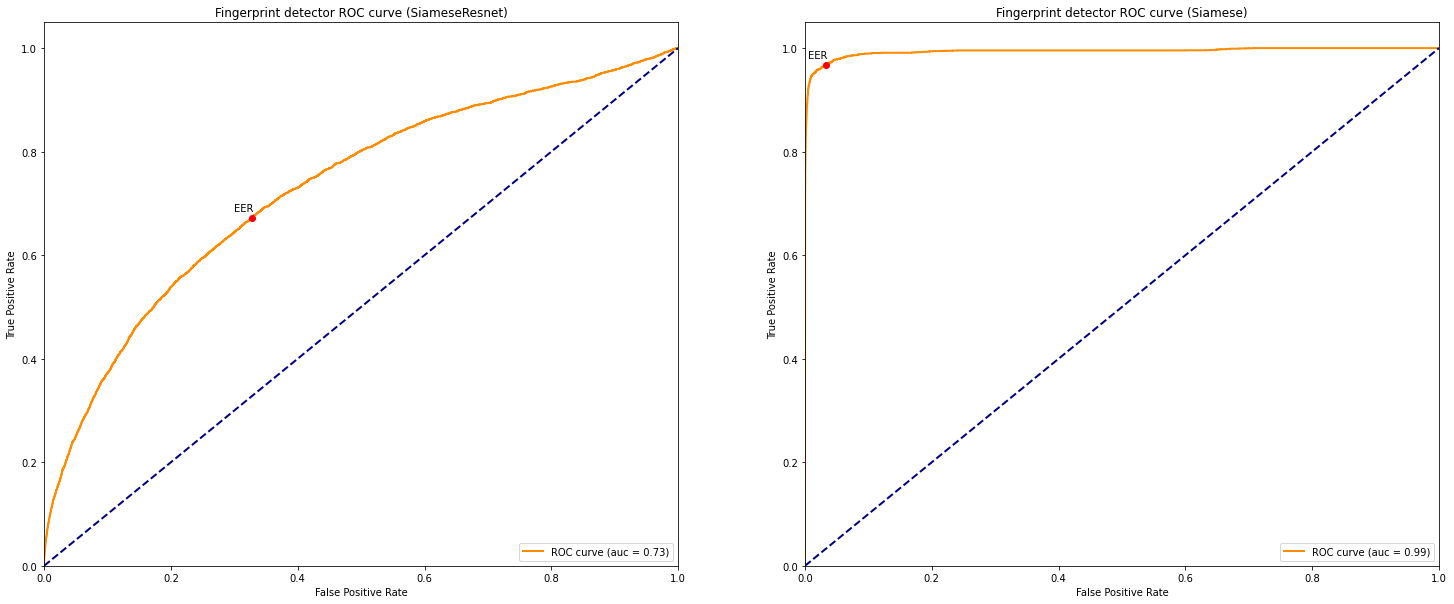

In [319]:
opt={"point":"EER"}
plt_compare_metrics(loggers,"plot_roc_curve",**opt)

In [320]:
metrics_dict={
            "f1":f1_score,
            "Accuracy":accuracy_score
        }

opt={"metrics_dict":metrics_dict}
opt["metric"]="f1"

  6%|▌         | 3/50 [00:00<00:01, 26.17it/s]

Optimal f1 value = 0.21 given at threshold 0.18


100%|██████████| 50/50 [00:01<00:00, 25.98it/s]


Optimal f1 value = 0.91 given at threshold 0.06


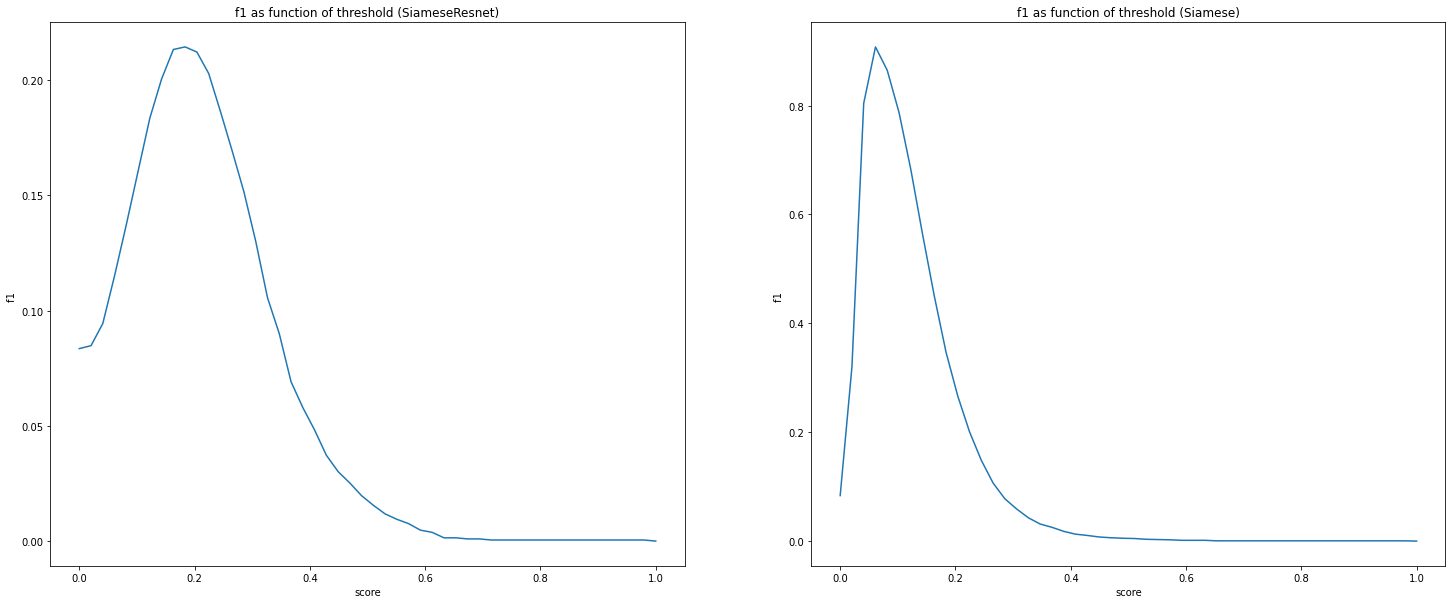

In [321]:
plt_compare_metrics(loggers,"plot_metric",**opt)


Optimal Accuracy value = 0.96 given at threshold 0.47
Optimal Accuracy value = 0.99 given at threshold 0.06


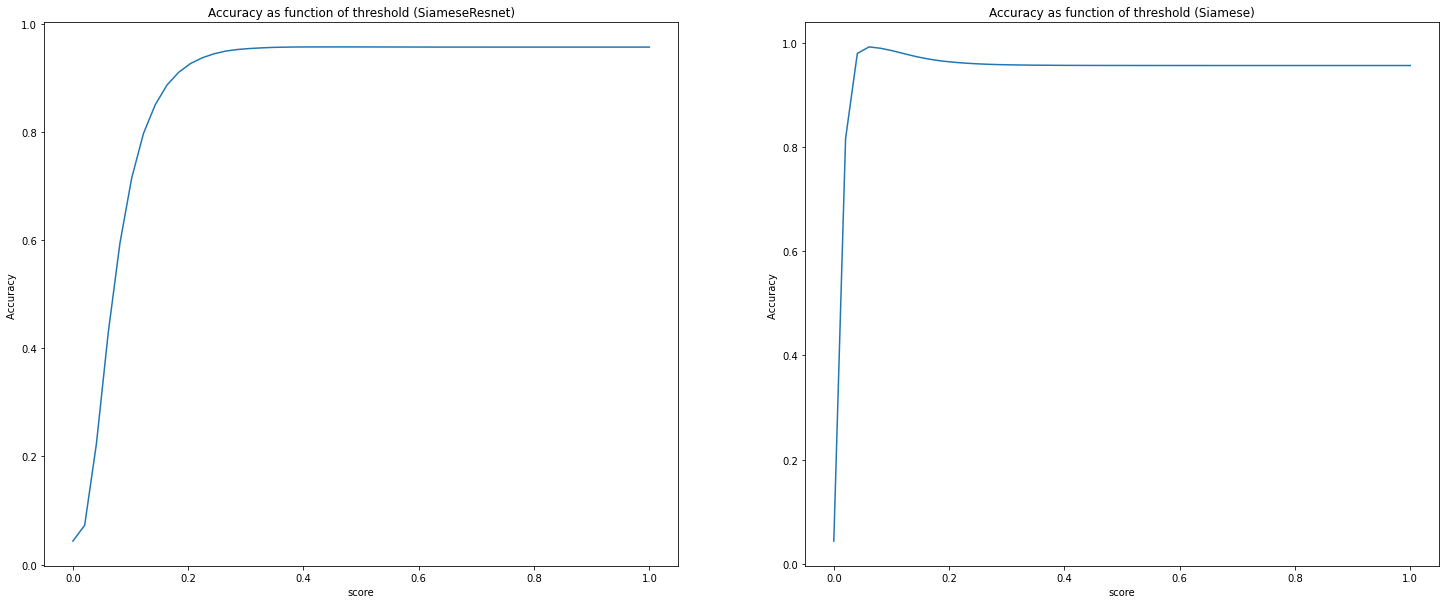

In [322]:
opt["metric"]="Accuracy"
plt_compare_metrics(loggers,"plot_metric",**opt)

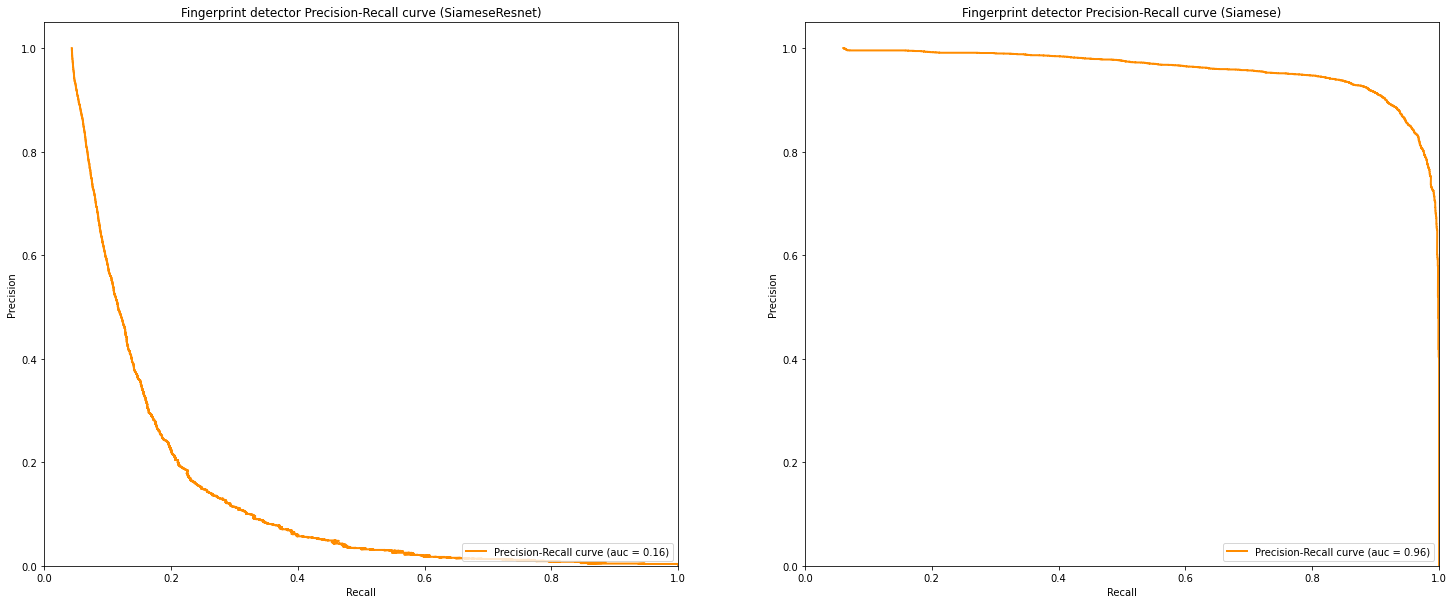

In [323]:
plt_compare_metrics(loggers,"plot_pr_curve")

100%|██████████| 26/26 [00:00<00:00, 2064.75it/s]


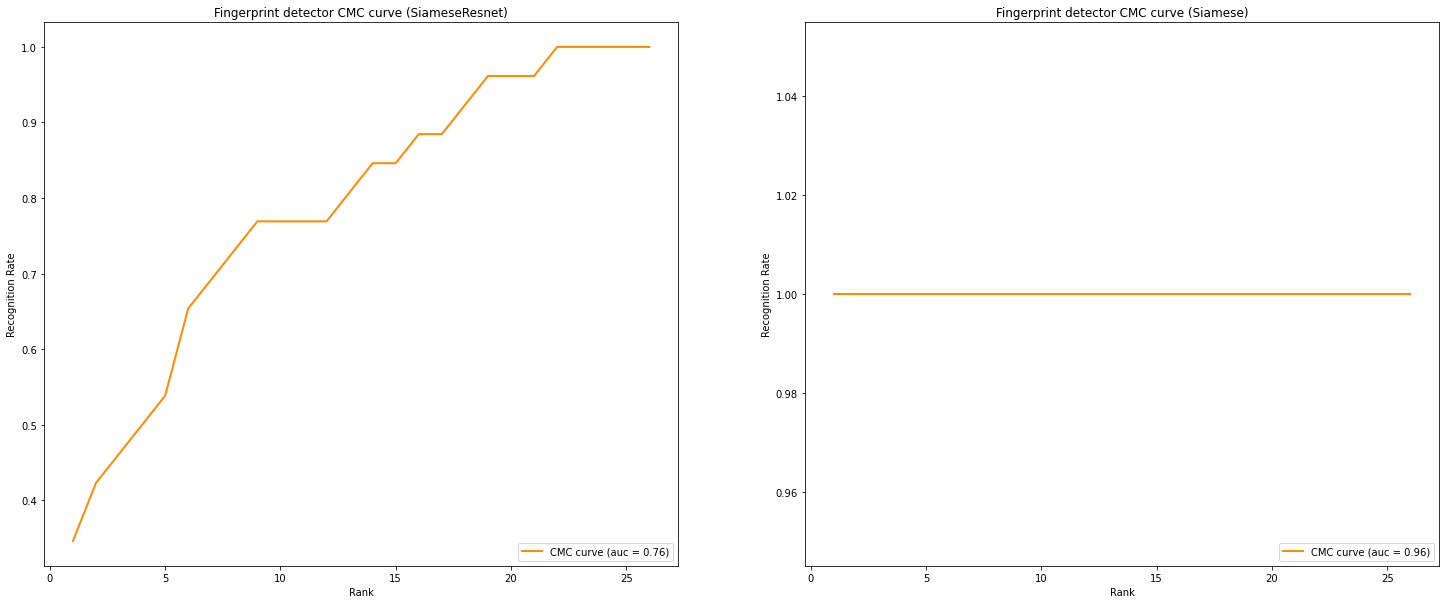

In [324]:
plt_compare_metrics(cmcs,"plot_CMC_curve")

# Advanced Classification

In [334]:
features_extractors = get_classifiers(features_extractors)

KNN results of SiameseResnet : Accuracy = 0.5272727272727272, MCC = 0.5076488169742849
KNN results of Siamese : Accuracy = 0.9818181818181818, MCC = 0.981109185441941


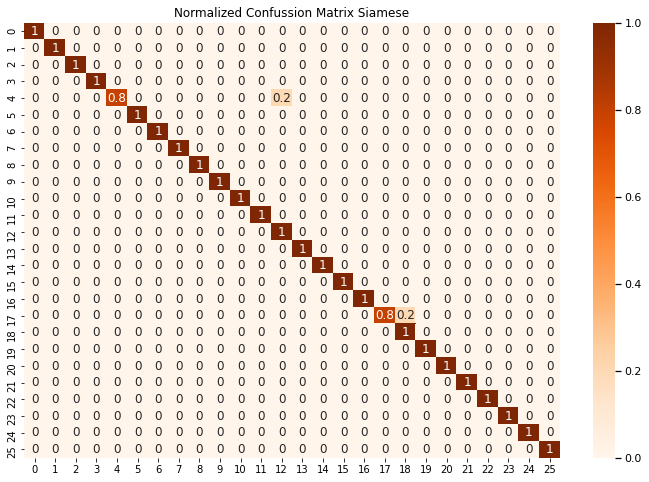

In [335]:
siamese_extractor = find_extractor("Siamese")
plot_confusion_matrix(siamese_extractor["true_labels"], 
                      siamese_extractor["predicted_labels"],
                      title="Normalized Confussion Matrix {}".format(siamese_extractor["descriptor"]))

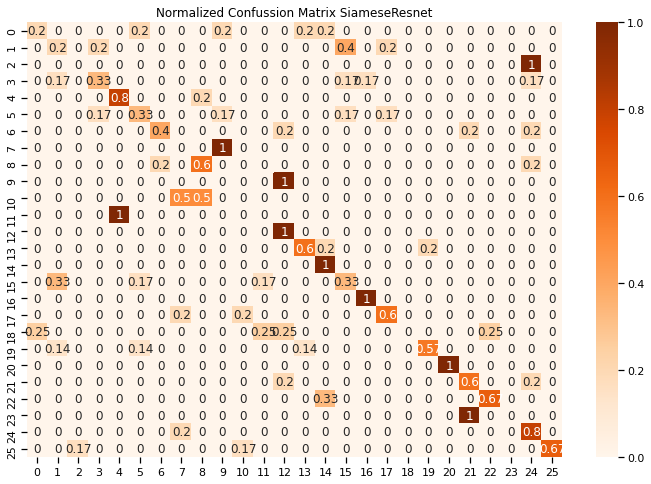

In [336]:
siamese_extractor = find_extractor("SiameseResnet")
plot_confusion_matrix(siamese_extractor["true_labels"], 
                      siamese_extractor["predicted_labels"],
                      title="Normalized Confussion Matrix {}".format(siamese_extractor["descriptor"]))